In [3]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#####################
# my files
# target model
from net_ import target_net
#from net_conv import target_net
# gan architectures
import gans_archs
# advgan training class
from GAN_ import advGAN

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

# functions
def transform_data(data_loader_obj):
    ims = []
    lls = []
    for imgs,lbls in data_loader_obj:
        for img,lbl in zip(imgs,lbls):
            ims.append(img)
            lls.append(lbl)
    ims = torch.stack(ims)
    lls = torch.stack(lls)
    return ims,lls

device:  cuda:0


In [4]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

# idx = get_indices(dataset, np.arange(num_of_classes))
# idx_test = get_indices(dataset_test, np.arange(num_of_classes))

# data_loader_rftarget = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
# data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
# data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
# data_loader_test = DataLoader(dataset_test, batch_size=1000, sampler = SubsetRandomSampler(idx_test))

# classes = np.arange(num_of_classes)

train1, train2 = random_split(dataset,[30000,30000])
data_loader_train1 = DataLoader(train1, batch_size=batch_size)
data_loader_train2 = DataLoader(train2, batch_size=batch_size)
data_loader_test = DataLoader(dataset_test, batch_size=1000)

In [5]:
# target model
n_estimators = 750
ims_train,lls_train = transform_data(data_loader_train1)
rf = RandomForestClassifier(n_estimators=n_estimators)
rf.fit(ims_train.reshape(len(ims_train),28*28).detach().numpy(),lls_train)
# save the model
PATH = './target_models/rf_model'+str(num_of_classes)+'classes'+'_nest'+str(n_estimators)+'.joblib'
dump(rf, PATH) 
# load the model
rf = load(PATH)

# test random forest accuracy
ims_test,lls_test = transform_data(data_loader_test)
print('accuracy: ', accuracy_score(rf.predict(ims_test.reshape(len(ims_test),28*28).detach().numpy()),lls_test))

accuracy:  0.9658


In [12]:
# import gen/disc
gen = gans_archs.Generator1()#include_noise=True,device=dev)
disc = gans_archs.Discriminator1()

# arguments for GAN training 
#target_net, gen, disc,
tar_criterion=nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
n_epochs=200
batch_size=128
lr=0.00001
display_step=500
gen_arch='cov'
###############################
gen_arch_num=1
disc_coeff=15.
hinge_coeff=1.
adv_coeff=1.
c=0.2
gen_path_extra='rftar_proba_genarch_'+str(gen_arch_num)
shape=(1,28,28)
num_of_classes=num_of_classes
################################

# initiate advgan
advgan = advGAN(rf.predict_proba,gen,disc,tar_criterion=tar_criterion,
                criterion=criterion,n_epochs=n_epochs,
                batch_size=batch_size,num_of_classes=num_of_classes,
                lr=lr,disc_coeff=disc_coeff,hinge_coeff=hinge_coeff,
                adv_coeff=adv_coeff,c=c,gen_path_extra=gen_path_extra,
                device=dev,display_step=display_step,shape=shape,gen_arch=gen_arch)

path:  ./advgan_models/rftar_proba_genarch_1_device_cuda:0_10classes_15p0disc_1p0hinge_0p2c_1p0adv.pt


epoch:  2
Step 500: Generator loss: 13.022819095893771, discriminator loss: 5.30492712926864


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.765625 | target model % correct: 0.96875 | avg. frobenius norm: 4.332577705383301
gen loss:  9.496056994812754  | disc loss:  1.8111028671264648


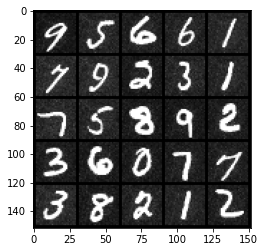

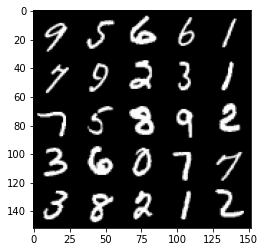

epoch:  4
Step 1000: Generator loss: 7.283231974464762, discriminator loss: 2.0713762469291708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.65625 | target model % correct: 0.96875 | avg. frobenius norm: 1.1597591638565063
gen loss:  5.724166893671139  | disc loss:  3.046363115310669


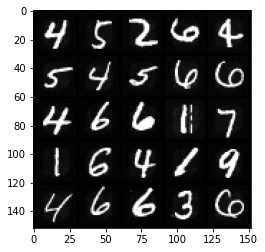

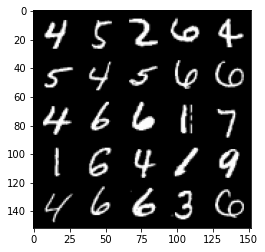

epoch:  6
Step 1500: Generator loss: 4.721650660253618, discriminator loss: 4.165754113197325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.4375 | target model % correct: 0.9453125 | avg. frobenius norm: 0.458415150642395
gen loss:  4.085743487456654  | disc loss:  5.352436542510986


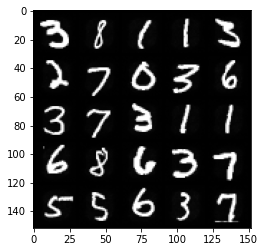

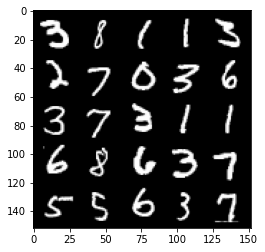

epoch:  8
Step 2000: Generator loss: 3.7472610052871613, discriminator loss: 6.604954902648926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.4140625 | target model % correct: 0.9765625 | avg. frobenius norm: 0.22817125916481018
gen loss:  3.6078684606172393  | disc loss:  8.159887313842773


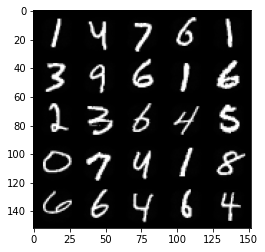

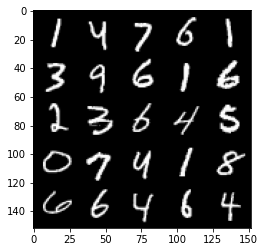

epoch:  10
Step 2500: Generator loss: 3.3917641163859957, discriminator loss: 8.146852461814879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.265625 | target model % correct: 0.96875 | avg. frobenius norm: 0.17190051078796387
gen loss:  3.326557902737794  | disc loss:  8.198799133300781


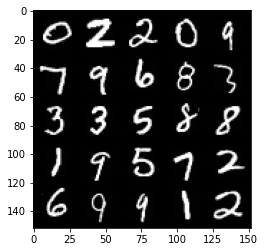

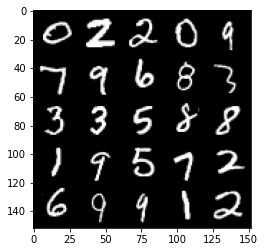

epoch:  12
Step 3000: Generator loss: 3.270616922952503, discriminator loss: 8.935540348052976


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.2890625 | target model % correct: 0.9921875 | avg. frobenius norm: 0.1573321521282196
gen loss:  3.289731350940129  | disc loss:  9.130012512207031


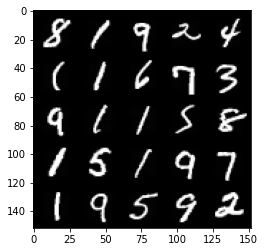

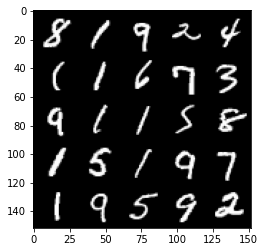

epoch:  14
Step 3500: Generator loss: 3.207531826084422, discriminator loss: 9.404567068099983


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.1796875 | target model % correct: 1.0 | avg. frobenius norm: 0.13609923422336578
gen loss:  3.282056949827452  | disc loss:  9.840171813964844


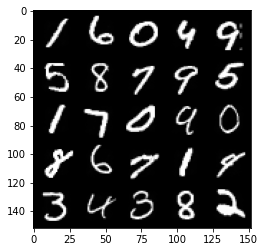

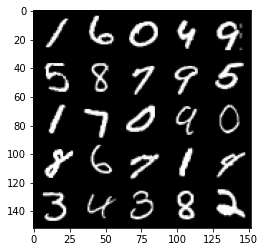

epoch:  17
Step 4000: Generator loss: 3.166073319571081, discriminator loss: 9.717861339569092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.203125 | target model % correct: 0.9609375 | avg. frobenius norm: 0.13200636208057404
gen loss:  3.1149397277428332  | disc loss:  9.663722038269043


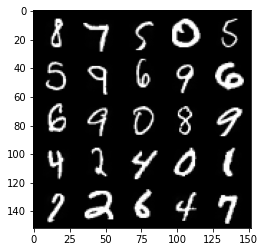

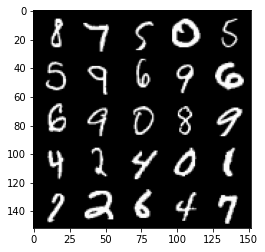

epoch:  19
Step 4500: Generator loss: 3.1378097543814425, discriminator loss: 9.940104963302606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.203125 | target model % correct: 0.96875 | avg. frobenius norm: 0.12346582114696503
gen loss:  3.1942644224240806  | disc loss:  10.206252098083496


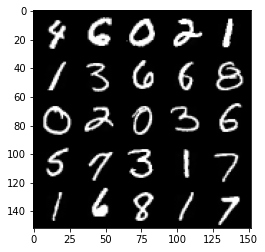

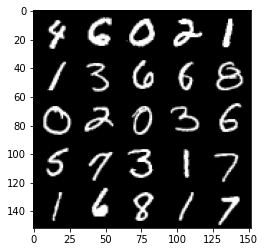

epoch:  21
Step 5000: Generator loss: 3.118575645081027, discriminator loss: 10.09206778526307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.1484375 | target model % correct: 0.9296875 | avg. frobenius norm: 0.11642228811979294
gen loss:  3.0956576649337695  | disc loss:  10.12745475769043


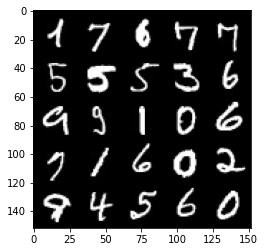

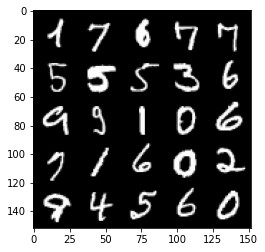

epoch:  23
Step 5500: Generator loss: 3.104212309062286, discriminator loss: 10.191472803115852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.0625 | target model % correct: 0.9609375 | avg. frobenius norm: 0.11328674852848053
gen loss:  3.067034833977808  | disc loss:  10.097171783447266


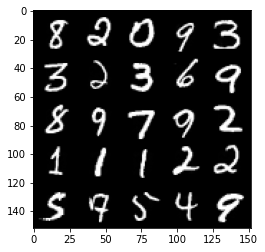

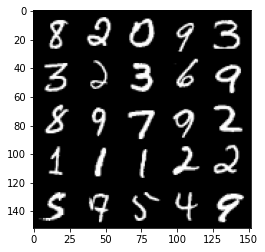

KeyboardInterrupt: 

In [13]:
%%time 
# train the gan
gen,disc = advgan.train(data_loader_train2)

In [ ]:
# notes
'''
When not concatenated with a noise vector, the robustness of the adv examples dies off. Results are illusrated 
in the form (epoch, % wrong, avg. frob. norm)
(5, 0.4, 4.4)
(25, 0.0, 0.29)
(40, 0.008, 0.15)
'''